## Real Datasets - MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.datasets import fetch_mldata
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import sklearn.neighbors as neigh_search
import scipy.sparse as sps
from consensus_clustering.load_data import load_fuzzy_data
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
import sys
# from scipy.spatial import distance
# from copy import deepcopy
# from timeit import default_timer as timer
# from datetime import timedelta
import importlib
%matplotlib inline

In [200]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

#----------------------------------------------------------------------
def compute_kernel(X, epsilon):
    m = np.shape(X)[0];
    cutoff = np.sqrt(3*epsilon);

    #calling nearest neighbor search class: returning a (sparse) distance matrix
    albero = neigh_search.radius_neighbors_graph(X, radius = cutoff, mode='distance', p=2, include_self=None)

    # computing the diffusion kernel value at the non zero matrix entries
    diffusion_kernel = np.exp(-(np.array(albero.data)**2)/(epsilon))
    
    # build sparse matrix for diffusion kernel
    kernel = sps.csr_matrix((diffusion_kernel, albero.indices, albero.indptr), dtype = float, shape=(m,m))
    kernel = kernel + sps.identity(m)  # accounting for diagonal elements
    
    return kernel;

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, labels, title=None, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set1(labels[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    if savetitle:
        plt.savefig(savetitle)

In [80]:
digits.images.shape

(1083, 8, 8)

In [82]:
digits.data.shape

(1083, 64)

In [83]:
digits.target.shape

(1083,)

### Visualize MNIST - random projection

Computing random projection


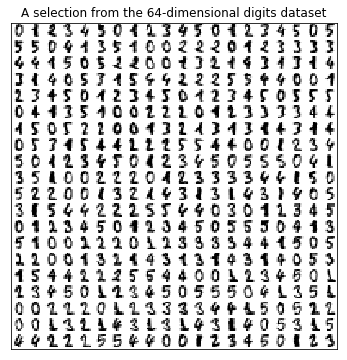

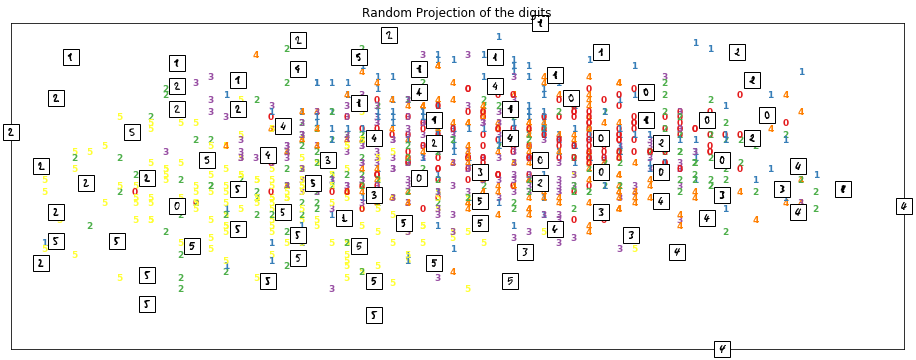

In [3]:
#----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.figure(figsize=(16, 6))
ax = plt.subplot(121)
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

#----------------------------------------------------------------------
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=89)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, y, "Random Projection of the digits")

### Visualize MNIST - diffusion coordinates

In [4]:
kernel = compute_kernel(X, epsilon=400.0)
alpha = 1.0
m = np.shape(X)[0]
D = sps.csr_matrix.sum(kernel, axis=0)
Dalpha = sps.spdiags(np.power(D,-alpha), 0, m, m)
kernel = Dalpha * kernel * Dalpha;

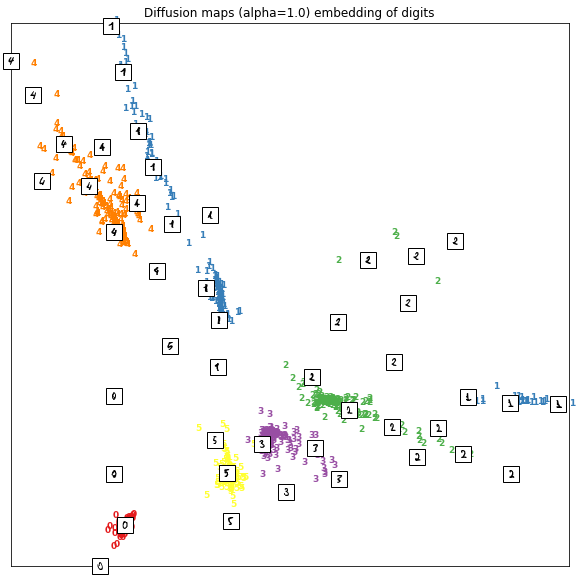

In [39]:
plot_against_coord = 2

X_se = manifold.spectral_embedding(kernel, n_components = plot_against_coord, eigen_solver = 'arpack')
X_se = np.column_stack((X_se[:, 0], X_se[:, plot_against_coord-1]))
#plot_embedding(X_se, 'Diffusion maps (alpha=1.0) embedding of digits')
plot_embedding(X_se, y, 'Diffusion maps (alpha=1.0) embedding of digits', figsize=(10, 10))

In [6]:
print(digits.data.shape)
print(digits.target.shape)
print(np.unique(digits.target))

(1083, 64)
(1083,)
[0 1 2 3 4 5]


In [7]:
np.unique(digits.data[900])

array([  0.,   1.,   3.,   5.,   6.,   8.,   9.,  10.,  11.,  12.,  13.,
        15.,  16.])

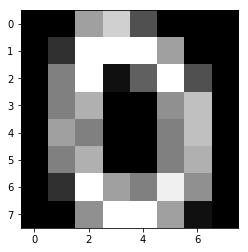

In [8]:
plt.imshow(digits.data[900].reshape((8, 8)), cmap='gray')

In [9]:
def param_search_dbscan(data, k_consensus, recluster_what, recluster_how, eps_arr, min_pts_arr):
    num_objects = len(eps_arr)
    dbscan_objects = [None] * num_objects
    dbscan_obj = None

    print("Fit DBSCAN objects")

    # Fit DBSCAN objects
    for i, (eps, minPts) in enumerate(zip(eps_arr, min_pts_arr)):
        sys.stdout.write('\reps: {0}, minPts: {1}'.format(eps, minPts))
        dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
        dbscan_obj.fit()
        dbscan_objects[i] = dbscan_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*dbscan_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(dbscan_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, dbscan_objects, consensus_obj

In [204]:
def plot_results(data, cl_objects, nmi_arr, consensus_obj, algorithm, arr_x, arr_y, savetitle = None):
    # Put labels in right order in to the labels array
    no_labels = [0] * len(data)
    clusterings_labels = []
    for obj in cl_objects:
        clusterings_labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
    print("Number of clusterings:", len(clusterings_labels))

    # Init plotting arrangement
    num_plots = len(cl_objects) + 2
    num_subplts_per_row = 6
    num_rows = np.ceil(num_plots / num_subplts_per_row).astype(int) + 1
    num_x_param = len(arr_x)
    num_y_param = len(arr_y)
    if num_y_param > 1:
        num_subplts_per_row = num_x_param
        num_rows = num_y_param + 1
    num_cols = min(num_subplts_per_row, num_plots)
    fig, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

    # Plot labels
    for i, ax in enumerate(axarr.flat):
        cur_x = i % num_subplts_per_row
        cur_y = i // num_subplts_per_row - 1 # do not count first row with original data and consensus
        ax.axis('off')
        if i==0:
            ax.set_title('Original data')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=no_labels, cmap='Set2', alpha=0.2)
        elif i==1:
            ax.set_title('Consensus')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=consensus_obj.cluster_labels, cmap='Set2', alpha=0.2)
        elif any((i < num_subplts_per_row, i-num_subplts_per_row >= len(clusterings_labels))):
            continue
        else:   
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=clusterings_labels[i-num_subplts_per_row], cmap='Set2', alpha=0.2)
            if algorithm == 'kmeans':
                ax.set_title('k = {:}, \nNMI = {:.3}'.format(k_arr[i-num_subplts_per_row], nmi_arr[i-num_subplts_per_row]))
            elif algorithm == 'dbscan':
#                 print(cur_x)
#                 print(cur_y)
                ax.set_title('eps = {:.3}, minPts = {:}\nNMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row]))
            else:
                print("ERROR: Could not recognize algorithm parameter!")
                break

    plt.tight_layout()
    plt.show()
    if savetitle:
        fig.savefig(savetitle)

Detected 7 clusters
Finished after 0:00:00.193555
Rate of noise in dataset: 0.102493
[-1  1  2  3  4  5  6  7]


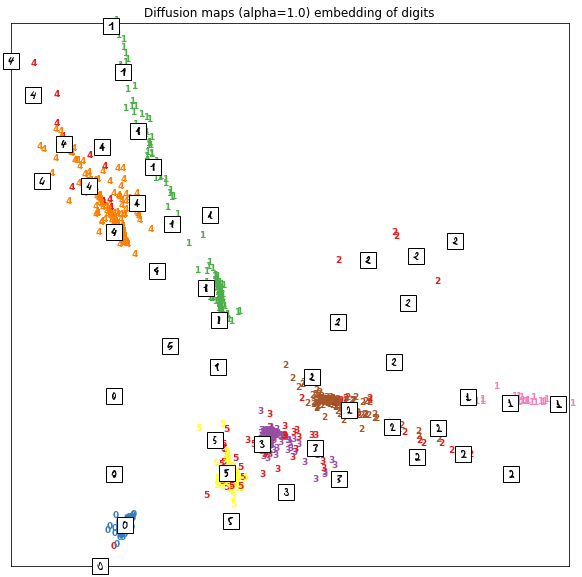

In [11]:
data = digits.data
eps = 23
minPts = 8

# Fit
dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=True)
dbscan_obj.fit()
single_labels = dbscan_obj.cluster_labels
#single_labels[single_labels == -1] = 0
print(np.unique(single_labels))

# Plot
plot_against_coord = 2
plot_embedding(X=X_se, labels=single_labels, title='Diffusion maps (alpha=1.0) embedding of digits', figsize=(10, 10))
# plot_embedding(X=X_se, labels=cl_objects_db[32].cluster_labels, title='Diffusion maps (alpha=1.0) embedding of digits', figsize=(10, 10))

In [12]:
# Set parameters:

# General
stride = 1
data = digits.data[::stride]
k_consensus = 10
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
n_eps = 6
n_min_pts = 6
eps_arr = np.linspace(5.0, 50.0, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 4
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

# KMeans
#num_objects = 3
#k_arr = np.arange(1,num_objects+1)

In [13]:
eps_arr

array([  5.,  14.,  23.,  32.,  41.,  50.])

In [14]:
min_pts_arr

array([4, 5, 6, 7, 8, 9])

#### maybe just do not try linear arrays, but for rough estimation first logarithmic? and then Intervallschachtelung?

In [19]:
from sklearn.manifold import TSNE

In [45]:
params = dict(n_components=2, 
          perplexity=30.0, 
          early_exaggeration=5.0, 
          learning_rate=70.0, 
          n_iter=1000, 
          n_iter_without_progress=30, 
          min_grad_norm=1e-07, 
          metric='cityblock', 
          init='random', 
          verbose=0, 
          random_state=None, 
          method='barnes_hut', 
          angle=0.5
             )
tsne = TSNE(**params)
X_tsne = tsne.fit_transform(X)

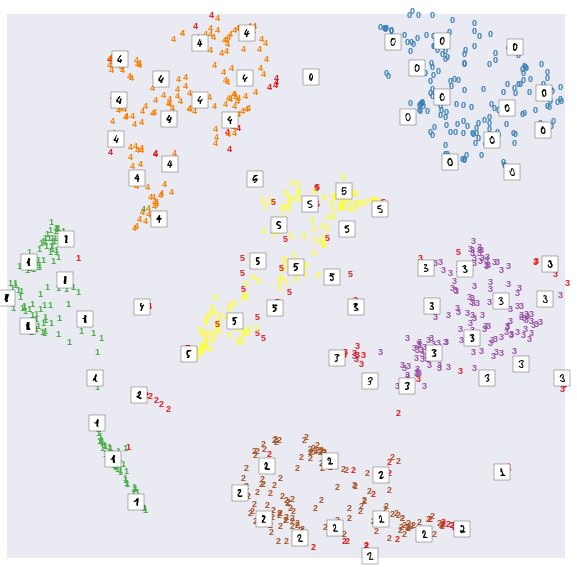

In [202]:
plot_embedding(X_tsne,single_labels,figsize = (10,10),savetitle = 'img/mnist_dbscan_tSNE.png')

In [203]:
nmi_arr_db, cl_objects_db, consensus_obj_db = param_search_dbscan(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 50.0, minPts: 9
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:02.007422
Stopping cluster number was reached.
Current number of clusters: 18
Current minimum cluster distance: 0.057
Consensus clustering terminated.
Finished after 0:00:12.077416
ANMI (average normalized mutual information) of consensus with clusterings: 0.192
Calculate NMI's


Number of clusterings: 36


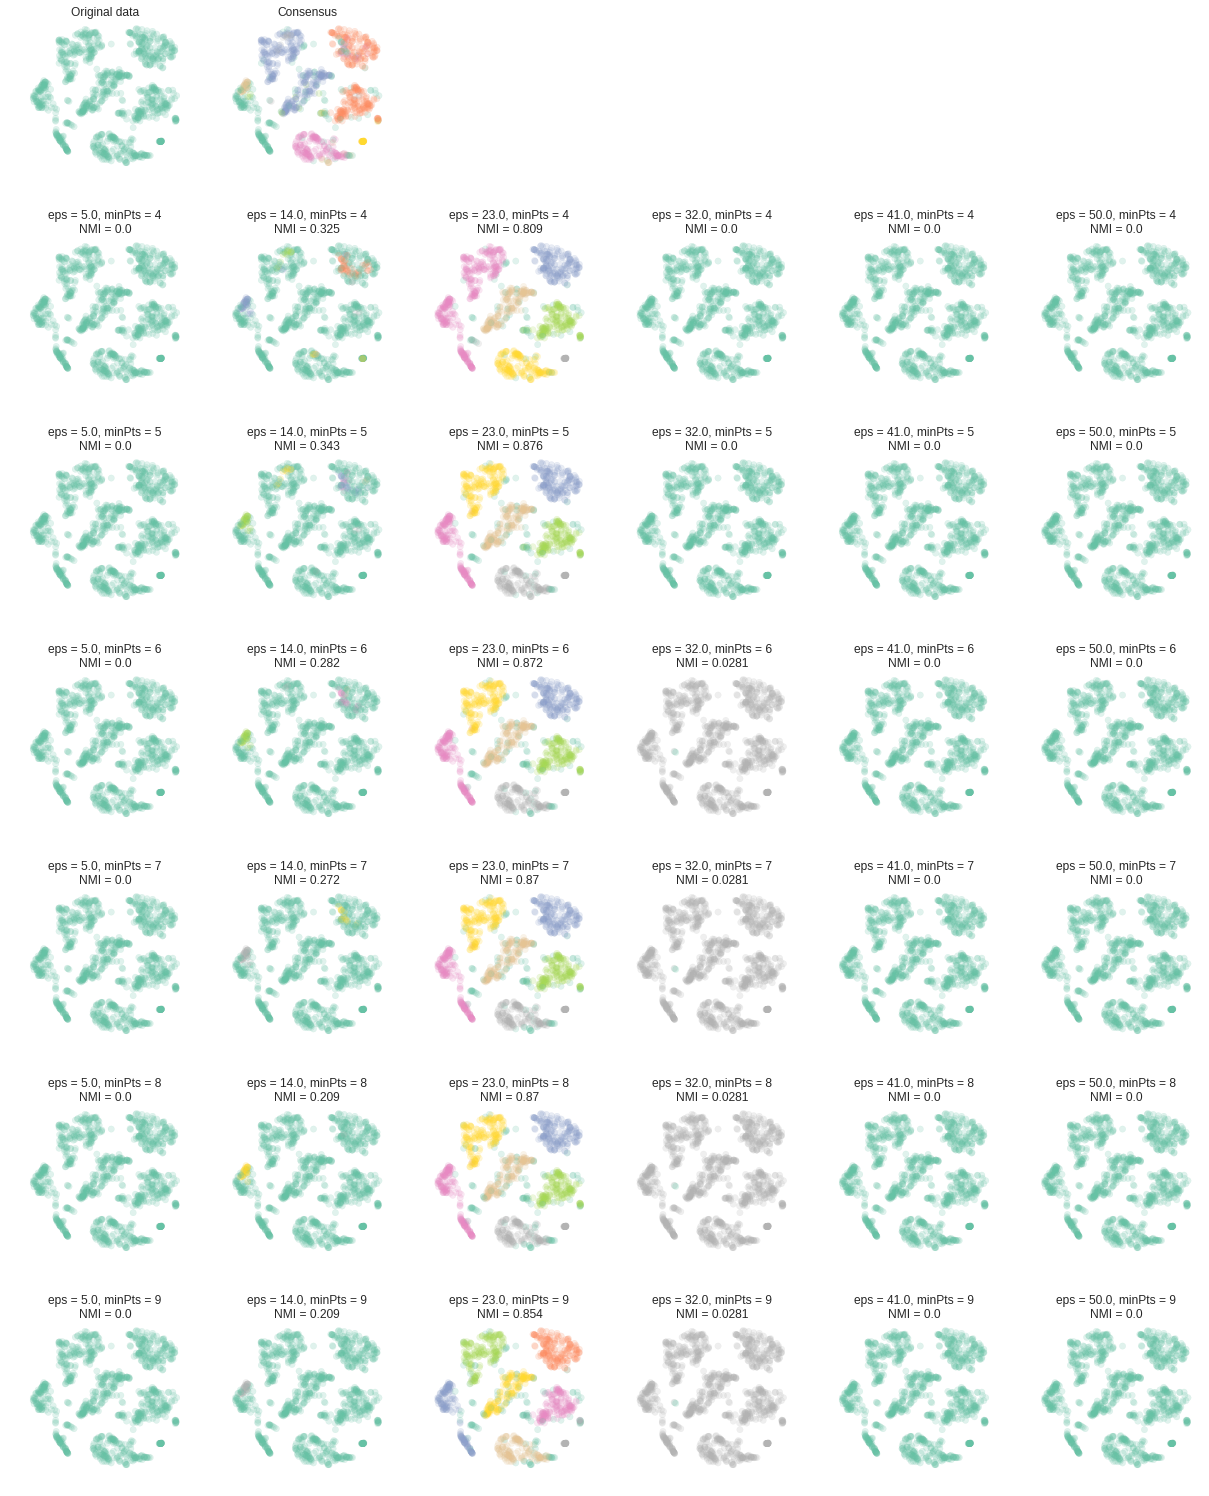

In [206]:
plot_results(data=X_tsne, cl_objects=cl_objects_db, nmi_arr=nmi_arr_db, consensus_obj=consensus_obj_db, algorithm='dbscan', arr_x=eps_arr, arr_y=min_pts_arr,
            savetitle = 'img/mnist_dbscan_consensus.png')

### MEANSHIFT

In [130]:
def param_search_meanshift(data, k_consensus, recluster_what, recluster_how, bandwidths):
    num_objects = len(bandwidths)
    ms_objects = [None] * num_objects
    ms_obj = None

    print("Fit Meanshift objects")

    # Fit DBSCAN objects
    for i, bd in enumerate(bandwidths):
        sys.stdout.write('\reps: {0}, minPts: {1}'.format(eps, minPts))
        ms_obj = density.MeanShift(data,bd,verbose=False)
        ms_obj.fit()
        ms_objects[i] = ms_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*ms_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(ms_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, ms_objects, consensus_obj

In [163]:
# Set parameters:

# General
stride = 1
data = digits.data[::stride]
k_consensus = 18
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
#n_eps = 6
#n_min_pts = 6
#eps_arr = np.linspace(5.0, 50.0, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
#min_pts_min = 4
#min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
#mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

n_bandwidths = 18
bandwidth_arr = np.linspace(1.0, 18.0, n_bandwidths)

In [164]:
nmi_arr_db, cl_objects_db, consensus_obj_db = param_search_meanshift(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    bandwidths = bandwidth_arr)

Fit Meanshift objects
eps: 23, minPts: 8
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:02.124763
Stopping cluster number was reached.
Current number of clusters: 18
Current minimum cluster distance: 0.19
Consensus clustering terminated.
Finished after 0:00:19.135938
ANMI (average normalized mutual information) of consensus with clusterings: 0.385
Calculate NMI's


In [196]:
def plot_results(data, cl_objects, nmi_arr, consensus_obj, algorithm, arr_x=None, arr_y=None,bandwidths=None,savetitle = None):
    # Put labels in right order in to the labels array
    no_labels = [0] * len(data)
    clusterings_labels = []
    for obj in cl_objects:
        clusterings_labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
    print("Number of clusterings:", len(clusterings_labels))

    # Init plotting arrangement
    num_plots = len(cl_objects) + 2
    num_subplts_per_row = 6
    num_rows = np.ceil(num_plots / num_subplts_per_row).astype(int) + 1
    num_rows = 4
    
    num_cols = min(num_subplts_per_row, num_plots)
    fig, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

    # Plot labels
    for i, ax in enumerate(axarr.flat):
        cur_x = i % num_subplts_per_row
        cur_y = i // num_subplts_per_row - 1 # do not count first row with original data and consensus
        ax.axis('off')
        if i==0:
            ax.set_title('Original data')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=no_labels, cmap='Set2', alpha=0.2)
        elif i==1:
            ax.set_title('Consensus')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=consensus_obj.cluster_labels, cmap='Set2', alpha=0.2)
        elif any((i < num_subplts_per_row, i-num_subplts_per_row >= len(clusterings_labels))):
            continue
        else:   
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=clusterings_labels[i-num_subplts_per_row], cmap='Set2', alpha=0.2)
            if algorithm == 'kmeans':
                ax.set_title('k = {:}, \nNMI = {:.3}'.format(k_arr[i-num_subplts_per_row], nmi_arr[i-num_subplts_per_row]))
            elif algorithm == 'dbscan':
#                 print(cur_x)
#                 print(cur_y)
                ax.set_title('eps = {:.3}, minPts = {:}\nNMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row]))
            elif algorithm == 'meanshift':
                ax.set_title('bandwidth = {:.3}\nNMI = {:.3}'.format(bandwidths[i-num_subplts_per_row], nmi_arr[i-num_subplts_per_row]))
            else:
                print("ERROR: Could not recognize algorithm parameter!")
                break

    plt.tight_layout()
    plt.show()
    if savetitle:
        fig.savefig(savetitle)

Number of clusterings: 18


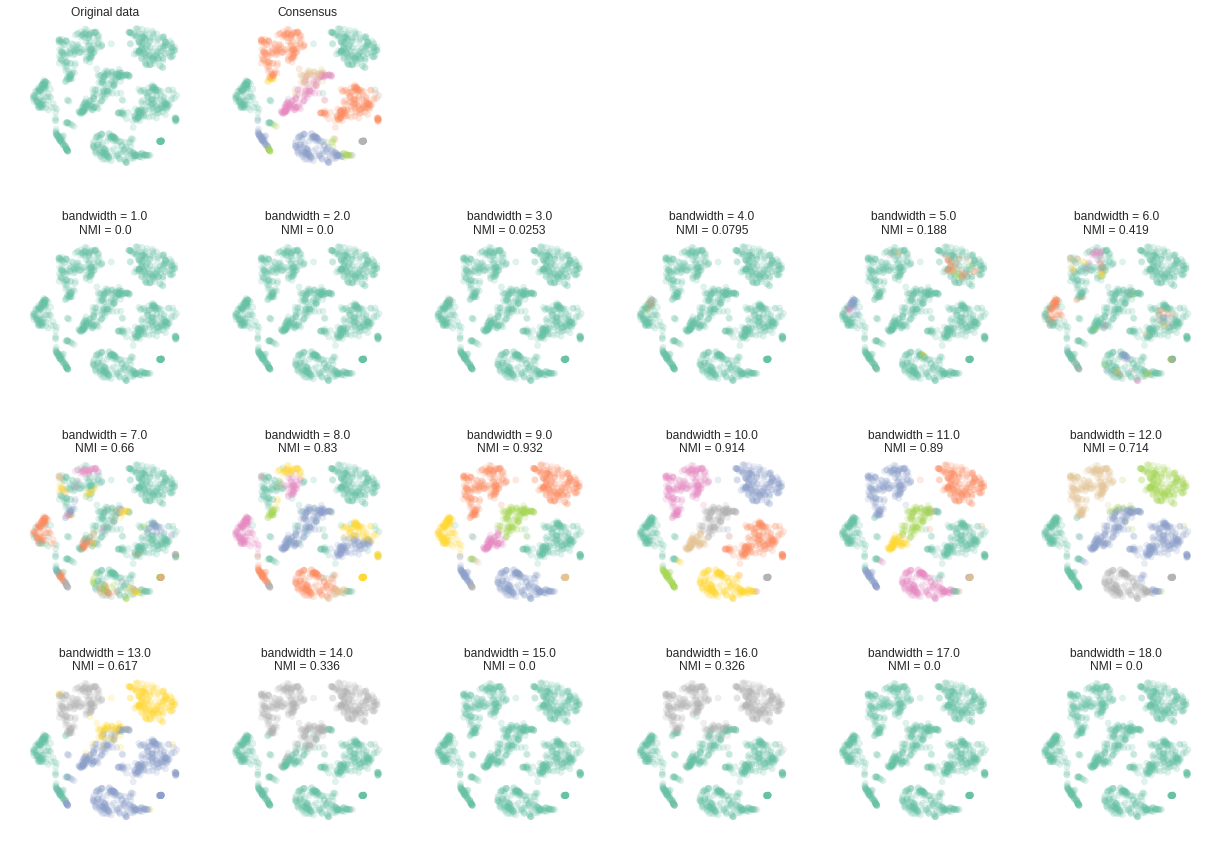

In [197]:
plot_results(data=X_tsne, cl_objects=cl_objects_db, nmi_arr=nmi_arr_db, consensus_obj=consensus_obj_db, algorithm='meanshift',bandwidths = bandwidth_arr,
            savetitle = 'img/mnist_meanshift_consensus-pdf')

In [177]:
ms = density.MeanShift(data, 9)
ms.fit()

76 iterations until termination.
Used bandwidth: 9.000000
Finished after 16.544770823998988
Number of clusters found: 14.000000
There is/are 11.000000 outliers
Max within cluster distance to center: 42.178222
Mean within cluster distance to center: 0.325198
Sum of within cluster squared errors: 11514.921430


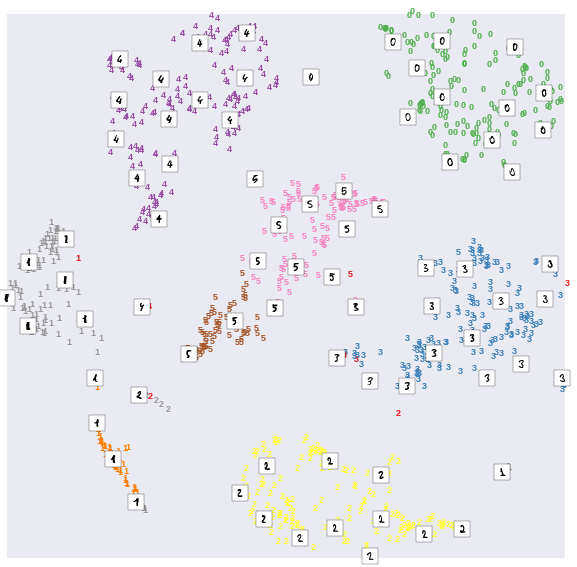

In [201]:
plot_embedding(X_tsne,ms.cluster_labels.astype(int),figsize = (10,10),savetitle='img/mnist_meanshift_tSNE.png')